In [1]:
import pathlib as plib
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# 24x32
model_dir = "../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_NORM_50epoch_seed0_MNISTSingleHidden300_01092022_21h38"

# 3x4
model_dir = "../MNIST_adafruit_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_NORM_50epoch_seed0_MNISTSingleHidden300_01092022_22h11"

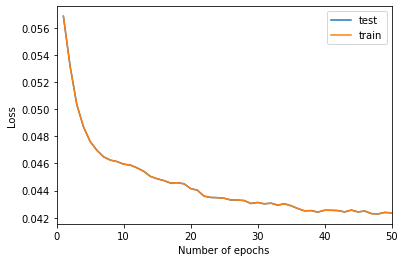

In [3]:
model_dir = plib.Path(model_dir)

train_loss = np.load(str(model_dir /"train_loss.npy"))
test_loss = np.load(str(model_dir / "test_loss.npy"))

n_epoch = np.arange(len(test_loss)) + 1
plt.plot(n_epoch,  test_loss, label="test")
plt.plot(n_epoch,  test_loss, label="train")
plt.legend()
# plt.ylim([0.86, 0.91])
plt.ylabel("Loss")
plt.xlabel("Number of epochs")
plt.xlim([0, 50]);


In [4]:
import numpy as np
import pathlib as plib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from lenslessclass.generator import SingleHidden
from lenslessclass.datasets import MNISTAugmented
import json
from pprint import pprint
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from waveprop.devices import slm_dict, sensor_dict
import torchvision.datasets as dset
import matplotlib


# Opening JSON file
f = open(str(model_dir / "metadata.json"))
metadata = json.load(f)
pprint(metadata)

{'batch_size': 100,
 'best_test_loss': 0.042282483913004404,
 'best_test_loss_epoch': 48,
 'dataset': '/home/bezzam/LenslessClassification/data/MNIST_adafruit_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_NORM',
 'hidden_dim': 300,
 'mean': 0.31785452365875244,
 'model': 'MNISTSingleHidden300',
 'noise_type': 'poisson',
 'seed': 0,
 'snr': 40.0,
 'std': 0.22363604605197906,
 'timestamp (DDMMYYYY_HhM)': '01092022_22h11'}


In [5]:
# load test set
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(metadata["mean"], metadata["std"])])
test_set = MNISTAugmented(path=metadata["dataset"], train=False, transform=trans, return_original="../data")

In [6]:
test_set[0][0].shape

torch.Size([1, 3, 4])

In [7]:
test_set[0][2].shape

torch.Size([1, 28, 28])

In [8]:
from lenslessclass.util import device_checks

# load model
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("CUDA available, using GPU.")
    device = "cuda:1"
else:
    device = "cpu"
    print("CUDA not available, using CPU.")

device, use_cuda, multi_gpu, device_ids = device_checks(device=device, single_gpu=False)


model = SingleHidden(
    input_shape=np.prod(test_set[0][0].shape), 
    hidden_dim=metadata["hidden_dim"], 
    n_output=np.prod(test_set[0][2].shape), 
)
if use_cuda:
    model = model.to(device)
model = nn.DataParallel(model, device_ids=device_ids)

# -- load from state dict
state_dict_fp = str(model_dir / "state_dict.pth")
model.load_state_dict(torch.load(state_dict_fp))


CUDA available, using GPU.
-- using 2 GPUs


<All keys matched successfully>

In [9]:
print("\nModel's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
module.linear1.weight 	 torch.Size([300, 12])
module.linear1.bias 	 torch.Size([300])
module.linear2.weight 	 torch.Size([784, 300])
module.linear2.bias 	 torch.Size([784])


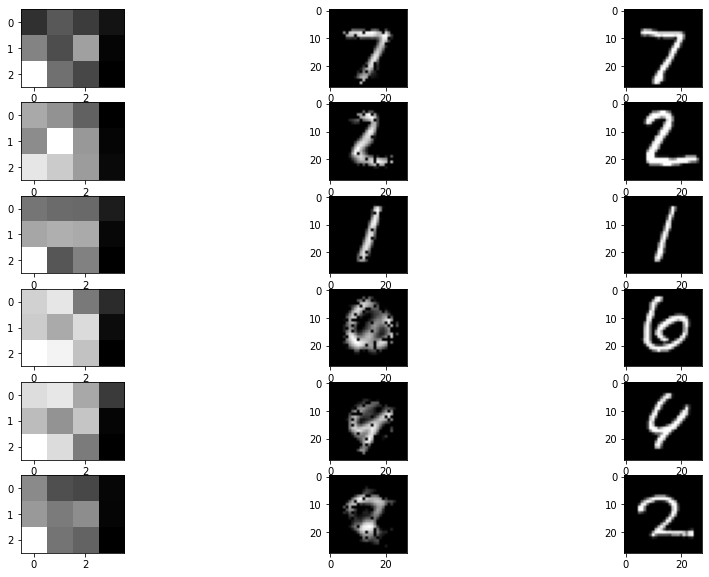

In [10]:
IDX = [0, 1, 2, 11, 121, 77]
# bad (3x4) : 11, 121, 77

plt.figure(figsize=(15,10))
for n, _idx in enumerate(IDX):
    # generate
    ex = test_set[_idx]
    gen_out = model(ex[0])
    gen_out_img = gen_out.detach().cpu().numpy().squeeze().reshape(28, 28)

    # plot
    plot_ind = n * 3 + 1
    plt.subplot(len(IDX), 3, plot_ind)
    plt.imshow(ex[0].detach().cpu().numpy().squeeze(), cmap="gray")
    plt.subplot(len(IDX), 3, plot_ind + 1)
    plt.imshow(gen_out_img, cmap="gray")
    plt.subplot(len(IDX), 3, plot_ind + 2)
    plt.imshow(ex[2].cpu().numpy().squeeze(), cmap="gray")

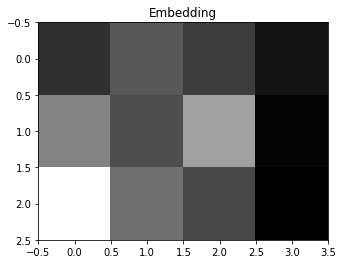

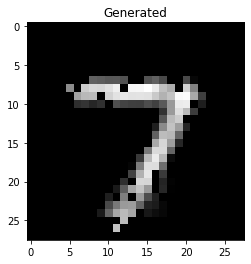

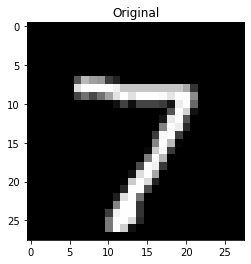

In [12]:
IDX = 0
# IDX = 11
# IDX = 121
# IDX = 77

# generate
ex = test_set[IDX]
gen_out = model(ex[0])
gen_out_img = gen_out.detach().cpu().numpy().squeeze().reshape(28, 28)

# plot
plt.imshow(ex[0].detach().cpu().numpy().squeeze(), cmap="gray")
plt.title("Embedding")
plt.show()
plt.imshow(gen_out_img, cmap="gray")
plt.title("Generated")
plt.show()
plt.imshow(ex[2].cpu().numpy().squeeze(), cmap="gray")
plt.title("Original")
plt.show()

In [13]:
ex[2].max()

tensor(1.)

# sweep over number of training examples